In [1]:
%cd ../
!pwd

/home/yoshio/git/second.pytorch
/home/yoshio/git/second.pytorch


In [2]:
import os
import pickle
from pathlib import Path
import re
from functools import partial
import json

import numpy as np
from scipy.special import logit, expit
from scipy import stats
from scipy.optimize import minimize_scalar
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
from matplotlib import patches
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image
import torch

from utils import *

In [3]:
def show_calibration(y_true, y_pred, variance_pred, n_bins):
    plt.figure(figsize=(10, 5))
    plt.suptitle("KITTI Dataset Car difficulty:2 3DIoU@0.70")
    plt.subplot(1,2,1)
    plt.title("Raw predicted sigmas")
    plt.hist(np.sqrt(variance_pred), range=(0, 1), bins=n_bins)
    plt.xlabel("Predicted sigma")
    plt.ylabel("Count")
    
    plt.subplot(1,2,2)
    prob_true, prob_pred = reg_calibration_curve(y_true, y_pred, variance_pred, n_bins)
    ece = np.abs(prob_true - prob_pred).mean()
    # ece = ((prob_true - prob_pred) ** 2).mean()
    plt.title("Raw Calibration plots")
    plt.plot(prob_pred, prob_true, "bs-", label="ECE=%.3f"%ece)
    plt.xlim(-0.05, 1.05)
    plt.xlabel("Prediction-confidences")
    plt.ylabel("Fraction of positives")
    plt.legend()
    
    plt.plot([0,1], [0,1], "k--")
    plt.show()

In [4]:
KITTI_INFO = Path(os.environ.get("KITTI_INFO", "/hdd/kitti/kitti_infos_val.pkl"))
CONF = os.environ.get("CONF", "pointpillars/car/xyres_16-boxunc-corrXY.config")
# MODEL = os.environ.get("MODEL", "pointpillars-car-xyres_16-boxunc-corrXY")
MODEL = os.environ.get("MODEL", "pointpillars-car-xyres_16-boxunc-vonMises")
print(KITTI_INFO, CONF, MODEL)

MODEL_DIR = Path(f"./model/{MODEL}")
checkpoint_json = json.loads((MODEL_DIR / "checkpoints.json").read_text())
GSTEP = int(re.search(r"voxelnet-(\d+)\.tckpt", checkpoint_json["latest_ckpt"]["voxelnet"]).group(1))
print("latest step:", GSTEP)

DATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result_kitti.pkl")
RAWDATA = Path(f"./model/{MODEL}/eval_results/step_{GSTEP}/result.pkl")
MODEL_WEIGHT = MODEL_DIR / f"voxelnet-{GSTEP}.tckpt"


/hdd/kitti/kitti_infos_val.pkl pointpillars/car/xyres_16-boxunc-corrXY.config pointpillars-car-xyres_16-boxunc-vonMises
latest step: 296960


In [5]:
with KITTI_INFO.open("rb") as f:
    gts = pickle.load(f)

with DATA.open("rb") as f:
    dets = pickle.load(f)

with RAWDATA.open("rb") as f:
    rawdets = pickle.load(f)

In [6]:
print("### rawdets ###")
print(rawdets[0].keys())
print("### dets ###")
print(dets[0].keys())
print("### gts ###")
print(gts[0].keys())
print("### gts.annos ###")
print(gts[0]["annos"].keys())

### rawdets ###
dict_keys(['box3d_lidar', 'scores', 'label_preds', 'metadata', 'boxvariance_lidar'])
### dets ###
dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'raw_detection_index', 'metadata', 'official/overlaps', 'official/3d_0.70/0/bin', 'official/3d_0.70/0/assigned_gt', 'official/3d_0.70/0/tp', 'official/3d_0.70/0/fp', 'official/3d_0.70/1/bin', 'official/3d_0.70/1/assigned_gt', 'official/3d_0.70/1/tp', 'official/3d_0.70/1/fp', 'official/3d_0.70/2/bin', 'official/3d_0.70/2/assigned_gt', 'official/3d_0.70/2/tp', 'official/3d_0.70/2/fp', 'num_points_in_det', 'hull_volumes_in_det', 'hull_bev_areas_in_det'])
### gts ###
dict_keys(['image', 'point_cloud', 'calib', 'annos'])
### gts.annos ###
dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'index', 'group_ids', 'difficulty', 'num_points_in_gt'])


In [7]:
data = {
    "y_true": [],
    "conf": [],
    "hull_lidar": [],
    "hull_bev": [],
    "X": [],
    "Y": [],
    "Z": [],
    "Rot": [],
    "W": [], # width
    "L": [], # longitude
    "H": [], # height
    "varX": [],
    "varY": [],
    "varZ": [],
    "varW": [],
    "varL": [],
    "varH": [],
    "Xgt": [],
    "Ygt": [],
    "Zgt": [],
    "Wgt": [],
    "Lgt": [],
    "Hgt": [],
    "Rotgt": [],
    "num_points_in_det": [],
    "xy_correlation_pred": [],
    "sample_idx": [],
}

for i, (rawdet, det, gt) in enumerate(tqdm(zip(rawdets, dets, gts), total=len(dets))):
    result = det["official/3d_0.70/2/assigned_gt"]
    mask = result != -1 # collect only tp
    data["y_true"].append(np.where(det["official/3d_0.70/2/bin"][mask] == 1, 1, 0))
    data["conf"].append(det["score"][mask])
    data["hull_lidar"].append(det["hull_volumes_in_det"][mask])
    data["hull_bev"].append(det["hull_bev_areas_in_det"][mask])
    raw_indices = det["raw_detection_index"][mask]
    # data["X"].append(det["location"][mask,0])
    # data["Y"].append(det["location"][mask,1])
    # data["Z"].append(det["location"][mask,2])
    data["X"].append(rawdet["box3d_lidar"][raw_indices,0])
    data["Y"].append(rawdet["box3d_lidar"][raw_indices,1])
    data["Z"].append(rawdet["box3d_lidar"][raw_indices,2])
    data["W"].append(rawdet["box3d_lidar"][raw_indices,3])
    data["L"].append(rawdet["box3d_lidar"][raw_indices,4])
    data["H"].append(rawdet["box3d_lidar"][raw_indices,5])
    data["Rot"].append(rawdet["box3d_lidar"][raw_indices, 6])
    data["varX"].append(rawdet["boxvariance_lidar"][raw_indices, 0])
    data["varY"].append(rawdet["boxvariance_lidar"][raw_indices, 1])
    data["varZ"].append(rawdet["boxvariance_lidar"][raw_indices, 2])
    data["varW"].append(rawdet["boxvariance_lidar"][raw_indices, 3])
    data["varL"].append(rawdet["boxvariance_lidar"][raw_indices, 4])
    data["varH"].append(rawdet["boxvariance_lidar"][raw_indices, 5])
    if "box_xy_correlation" in rawdet:
        data["xy_correlation_pred"].append(rawdet["box_xy_correlation"][raw_indices, 0])
    else:
        data["xy_correlation_pred"].append(np.zeros_like(raw_indices))
    indices = result[mask]
    try:
        loc = gt["annos"]["location"][indices]
        dims = gt["annos"]["dimensions"][indices]
        rots = gt["annos"]["rotation_y"][indices]
        gt_boxes_camera = np.concatenate([loc, dims, rots[..., np.newaxis]], axis=1)
        rect = gt["calib"]["R0_rect"]
        Trv2c = gt["calib"]["Tr_velo_to_cam"]
        gt_boxes_lidar = box_camera_to_lidar(gt_boxes_camera, rect, Trv2c)

        # TODO: add variance of box[5]?
        change_box3d_center_(gt_boxes_lidar, [0.5, 0.5, 0], [0.5, 0.5, 0.5])
        data["Xgt"].append(gt_boxes_lidar[:,0])
        data["Ygt"].append(gt_boxes_lidar[:,1])
        data["Zgt"].append(gt_boxes_lidar[:,2])
        data["Wgt"].append(gt_boxes_lidar[:,3])
        data["Lgt"].append(gt_boxes_lidar[:,4])
        data["Hgt"].append(gt_boxes_lidar[:,5])
        data["Rotgt"].append(gt_boxes_lidar[:,6])
    except:
        print(indices)
        raise
    data["num_points_in_det"].append(det["num_points_in_det"][mask])
    data["sample_idx"].append(np.full(mask.sum(), i))

df = pd.DataFrame({key: np.concatenate(val) for key, val in data.items()})
df["angle"] = np.arctan2(df.Y, df.X)
df["angle_gt"] = np.arctan2(df.Ygt, df.Xgt)
df["angle_deg"] = np.arctan2(df.Y, df.X) * 180 / np.pi
df["hull_lidar_ratio"] = df.hull_lidar / (df.W * df.H * df.L)
df["hull_bev_ratio"] = df.hull_bev / (df.W * df.L)
df["RotCam"] = (df.Rot + df.angle) % (2 * np.pi)
df["RotCamgt"] = (df.Rotgt + df.angle_gt) % (2 * np.pi)
df["Sigma_xy"] = df.xy_correlation_pred * np.sqrt(df.varX * df.varY)

assert np.all(df.y_true == 1)
df


  0%|          | 0/3769 [00:00<?, ?it/s]

,y_true,conf,hull_lidar,hull_bev,X,Y,Z,Rot,W,L,...,xy_correlation_pred,sample_idx,angle,angle_gt,angle_deg,hull_lidar_ratio,hull_bev_ratio,RotCam,RotCamgt,Sigma_xy
0,1,0.559178,0.779243,2.236552,34.702927,-3.215833,-1.319051,1.656544,1.598930,3.782332,...,0,1,-0.092404,-0.090695,-5.294336,0.088245,0.369820,1.564140,4.612491,0.0
1,1,0.805566,1.608013,4.304275,38.419353,15.706939,-0.983707,1.589165,1.672592,3.848487,...,0,2,0.388094,0.387527,22.236158,0.175674,0.668682,1.977259,1.957527,0.0
2,1,0.747337,2.940483,5.004598,32.032745,2.672920,-0.415380,4.990107,1.626998,4.199973,...,0,4,0.083251,0.086457,4.769903,0.282326,0.732379,5.073357,5.069643,0.0
3,1,0.672046,1.928790,4.065533,19.779984,12.843830,-0.796283,-0.419032,1.629394,3.994797,...,0,4,0.575907,0.565690,32.997063,0.199761,0.624592,0.156876,0.145690,0.0
4,1,0.845298,2.839315,3.927886,8.115088,1.211632,-0.753692,1.879528,1.573661,3.708739,...,0,5,0.148211,0.144562,8.491877,0.310349,0.673010,2.027740,2.044562,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8450,1,0.723867,1.921861,3.209947,12.669714,7.003936,-0.767573,-3.215248,1.722576,4.230014,...,0,3768,0.504997,0.499247,28.934225,0.164822,0.440532,3.572935,3.549247,0.0
8451,1,0.705097,0.102409,0.247390,19.062107,-5.707148,-0.687623,0.046423,1.591243,3.936842,...,0,3768,-0.290904,-0.289460,-16.667572,0.011293,0.039491,6.038705,5.953725,0.0
8452,1,0.669725,0.202539,1.391755,26.441532,6.858867,-0.766901,0.053396,1.585931,3.957633,...,0,3768,0.253804,0.264905,14.541877,0.022575,0.221739,0.307199,3.384905,0.0
8453,1,0.639594,1.095662,1.274765,15.273860,7.072339,-0.356538,-0.033066,1.799285,4.213314,...,0,3768,0.433641,0.438630,24.845808,0.077948,0.168154,0.400575,0.398630,0.0


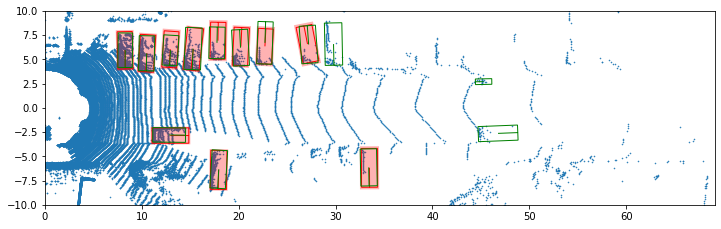

,y_true,conf,hull_lidar,hull_bev,X,Y,Z,Rot,W,L,...,xy_correlation_pred,sample_idx,angle,angle_gt,angle_deg,hull_lidar_ratio,hull_bev_ratio,RotCam,RotCamgt,Sigma_xy
6507,1,0.817517,2.513440,4.520281,12.954088,-2.852070,-0.976179,4.711187,1.585116,3.791735,...,0,2881,-0.216710,-0.214457,-12.416574,0.298283,0.752084,4.494477,4.508728,0.0
6508,1,0.705376,1.495452,3.316888,17.926411,-6.398226,-0.750886,0.014824,1.663273,4.017285,...,0,2881,-0.342823,-0.339228,-19.642305,0.147558,0.496403,5.955186,6.003957,0.0
6509,1,0.704435,0.701581,1.170740,10.524937,5.642554,-0.841837,0.064494,1.590157,3.823292,...,0,2881,0.492119,0.492752,28.196329,0.077383,0.192567,0.556613,0.512752,0.0
6510,1,0.687735,0.000000,0.000000,17.857121,6.943636,-0.735101,-3.122244,1.578341,3.795754,...,0,2881,0.370852,0.361665,21.248274,0.000000,0.000000,3.531794,3.524850,0.0
6511,1,0.680187,1.905432,3.149340,8.265014,5.949386,-0.849273,-0.018682,1.562015,3.849367,...,0,2881,0.623910,0.623122,35.747387,0.212071,0.523775,0.605228,0.633122,0.0
6512,1,0.671768,0.104593,0.478745,22.707085,6.359770,-0.737045,-3.087001,1.555999,3.636097,...,0,2881,0.273082,0.287678,15.646425,0.012554,0.084617,3.469266,3.460863,0.0
6513,1,0.667946,0.767719,1.223897,15.311824,6.080924,-0.728241,0.113698,1.652862,4.386402,...,0,2881,0.378038,0.380667,21.659962,0.067054,0.168811,0.491736,0.420667,0.0
6514,1,0.630336,0.297546,0.705677,12.948258,6.044420,-0.724424,0.067321,1.532814,3.739947,...,0,2881,0.436748,0.430291,25.023796,0.035268,0.123098,0.504068,0.490291,0.0
6515,1,0.588009,0.123440,0.411680,20.223146,6.333749,-0.859325,-3.092183,1.578429,3.929577,...,0,2881,0.303516,0.298815,17.390194,0.014014,0.066373,3.494518,3.388815,0.0
6516,1,0.338100,0.264744,0.699771,27.102644,6.589911,-0.673875,-3.334333,1.655983,3.809018,...,0,2881,0.238518,0.236143,13.666068,0.027133,0.110940,3.187370,3.306143,0.0


In [8]:
def annot2poly(X, Y, W, L, Rot):
    Rot = -Rot + np.pi
    poly = np.array([[X, Y], [X, Y + L/2], [X + W/2, Y + L/2], [X + W/2, Y - L/2], [X - W/2, Y - L/2], [X - W/2, Y + L/2], [X, Y + L/2]])
    poly = (poly - [X, Y]) @ np.array([[np.cos(Rot), np.sin(Rot)], [-np.sin(Rot), np.cos(Rot)]]) + [X, Y]
    return poly

def show_field(sub_df, show_img=True):
    if show_img:
        _fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    else:
        _fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        ax = [ax]
    
    assert sub_df.sample_idx.nunique() == 1
    show_index = sub_df.sample_idx.iloc[0]

    xlim = [0, 1]
    ylim = [0, 1]
    for _index, row in sub_df.iterrows():
        ax[0].add_patch(
            patches.Polygon(annot2poly(row.X, row.Y, row.W, row.L, row.Rot), closed=False, edgecolor='red', fill=False)
        )
        sigmaW = np.sqrt(row.varW)
        sigmaL = np.sqrt(row.varL)
        ax[0].add_patch(
            patches.Polygon(annot2poly(row.X, row.Y, row.W+sigmaW*2, row.L+sigmaL*2, row.Rot), closed=False, facecolor='red', alpha=0.3)
        )

        xlim[0] = min(xlim[0], row.X - row.W/2)
        xlim[1] = max(xlim[1], row.X + row.W/2)
        ylim[0] = min(ylim[0], row.Y - row.L/2)
        ylim[1] = max(ylim[1], row.Y + row.L/2)

    gt = gts[show_index]
    loc = gt["annos"]["location"]
    dims = gt["annos"]["dimensions"]
    rots = gt["annos"]["rotation_y"]
    gt_boxes_camera = np.concatenate([loc, dims, rots[..., np.newaxis]], axis=1)
    rect = gt["calib"]["R0_rect"]
    Trv2c = gt["calib"]["Tr_velo_to_cam"]
    gt_boxes_lidar = box_camera_to_lidar(gt_boxes_camera, rect, Trv2c)
    for Xgt, Ygt, _, Wgt, Lgt, _, Rotgt in gt_boxes_lidar:
        poly = annot2poly(Xgt, Ygt, Wgt, Lgt, Rotgt)
        ax[0].add_patch(
            patches.Polygon(poly, closed=False, edgecolor='green', fill=False)
        )

    v_path = os.path.join(os.path.dirname(os.path.abspath(KITTI_INFO)), gt["point_cloud"]["velodyne_path"])
    points_v = np.fromfile(
        v_path, dtype=np.float32, count=-1).reshape([-1, 4])
    ax[0].scatter(points_v[:,0], points_v[:,1], s=0.3)
    # ax[0].set_xlim(xlim[0], xlim[1])
    # ax[0].set_ylim(ylim[0], ylim[1])
    ax[0].set_xlim(0, 69.12)
    ax[0].set_ylim(-10, 10)
    ax[0].set_aspect('equal')

    if show_img:
        path = os.path.join(os.path.dirname(os.path.abspath(KITTI_INFO)), gt["image"]['image_path'])
        print(path)
        ax[1].imshow(np.asarray(Image.open(path)))

    plt.show()

sub_df = df[df.sample_idx == 2881]
show_field(sub_df, False)
sub_df

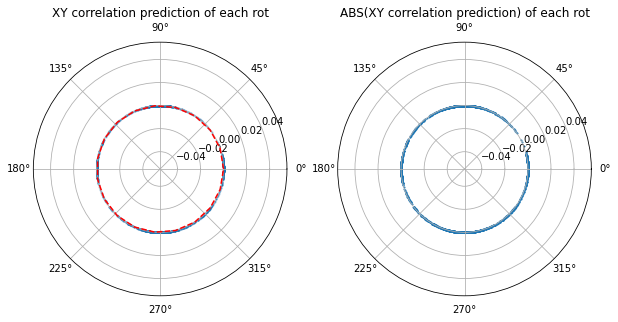

In [9]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1, polar=True)
ax.set_title(f"XY correlation prediction of each rot")
ax.scatter(df.Rot, df.xy_correlation_pred, s=1, alpha=0.3)
ax.plot(np.linspace(0, np.pi*2, 20), np.zeros(20), "r--")

ax = plt.subplot(1,2,2, polar=True)
ax.set_title(f"ABS(XY correlation prediction) of each rot")
ax.scatter(df.Rot, np.abs(df.xy_correlation_pred), s=1)
plt.show()

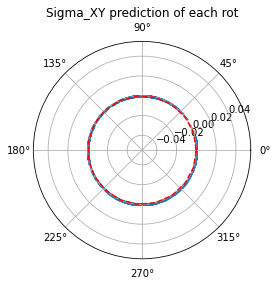

In [10]:
ax = plt.subplot(1,1,1, polar=True)
ax.set_title(f"Sigma_XY prediction of each rot")
ax.scatter(df.Rot, df.Sigma_xy, s=1)
ax.plot(np.linspace(0, np.pi*2, 20), np.zeros(20), "r--")
plt.show()

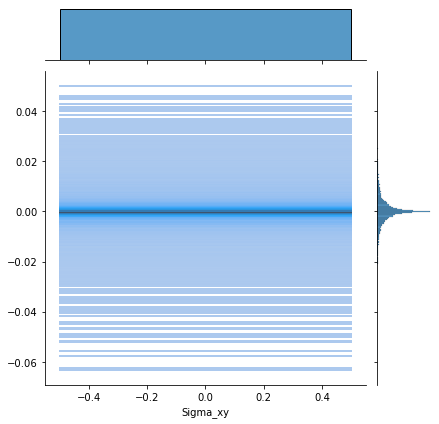

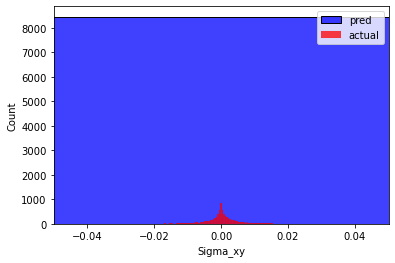

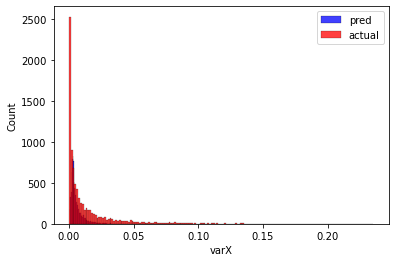

In [11]:
sns.jointplot(
    x=df.Sigma_xy,
    y=(df.X - df.Xgt) * (df.Y - df.Ygt),
    kind="hist")
plt.show()

sns.histplot(x=df.Sigma_xy, color="b", label="pred")
sns.histplot(x=(df.X - df.Xgt) * (df.Y - df.Ygt), color="r", label="actual")
plt.legend()
plt.xlim(-0.05, 0.05)
plt.show()

sns.histplot(x=df.varX, color="b", label="pred")
sns.histplot(x=(df.X - df.Xgt) ** 2, color="r", label="actual")
plt.legend()
plt.show()


明らかに傾いたbboxのX,Y lossの推定にはcorrelationが存在する

ECE: 0.16525724263578134
Sharpness: 2.1331218e-05
2.9792152245978465 2.07645260995205
3.0294829970764865 2.055917444326603
2.9700428970540234 2.012768015210474
calibrated ECE: 0.0383939760836622
calibrated Sharpness: 0.00013077443437125325


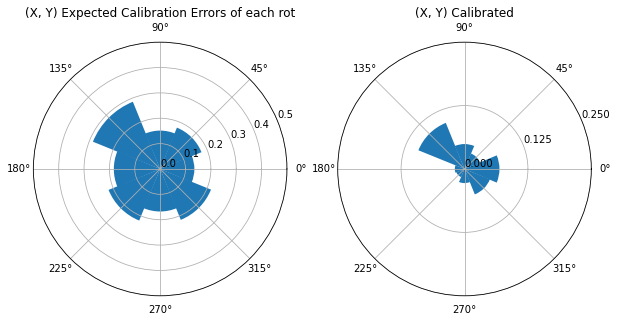

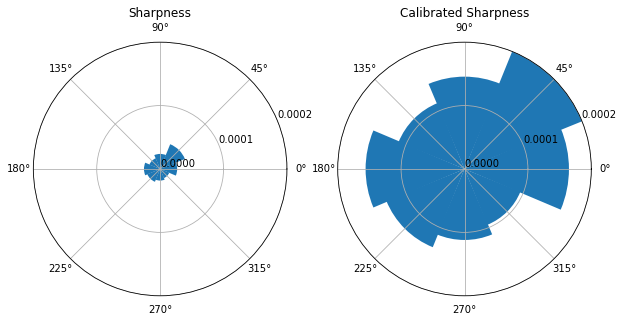

In [22]:
def make_cov(df):
    variance_pred = df[["varX", "varY"]].to_numpy()
    cov_pred = np.array([np.diag(variance) for variance in variance_pred])
    return cov_pred

def show(infer, cov_fn=make_cov):
    n_zbins = 8
    zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
    zbinids = np.digitize((df.Rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1

    plt.figure(figsize=(10,5))
    ax = plt.subplot(1,2,1, polar=True)
    ax.set_title(f"(X, Y) Expected Calibration Errors of each rot")

    y_true = df[["Xgt", "Ygt"]].to_numpy()
    y_pred = df[["X", "Y"]].to_numpy()
    cov_pred = cov_fn(df)

    x = zbins[:n_zbins]
    eces = []
    sharps = []
    for zi in range(n_zbins):
        prob_true, prob_pred = reg_calibration_curve_nd(y_true[zbinids == zi], y_pred[zbinids == zi], cov_pred[zbinids == zi], n_bins=20)
        eces.append(np.abs(prob_true - prob_pred).mean())
        sharps.append(np.mean(np.linalg.det(cov_pred[zbinids == zi])))
    ax.bar(x, eces)
    ax.set_yticks(np.linspace(0.0, 0.5, 6, endpoint=True))
    ax.set_ylim(0, 0.5)
    print("ECE:", sum([eces[zi] * (zbinids == zi).sum() for zi in range(n_zbins)]) / len(y_true))
    assert np.all(np.linalg.det(cov_pred) > 0)
    print("Sharpness:", np.mean(np.linalg.det(cov_pred)))

    ax = plt.subplot(1,2,2, polar=True)
    kf = KFold(3, shuffle=False)

    y_trues = []
    y_preds = []
    calibed = []
    for train_idx, val_idx in kf.split(np.arange(len(df)), np.arange(len(df))):
        inst = infer(y_true[train_idx], y_pred[train_idx], cov_pred[train_idx], df.Rot.iloc[train_idx].to_numpy())
        calibed.append(inst(cov_pred[val_idx], df.Rot.iloc[val_idx].to_numpy()))
        y_trues.append(y_true[val_idx])
        y_preds.append(y_pred[val_idx])
    calibed = np.concatenate(calibed)
    y_true = np.concatenate(y_trues)
    y_pred = np.concatenate(y_preds)

    ax.set_title(f"(X, Y) Calibrated")

    x = zbins[:n_zbins]
    eces = []
    calibed_sharps = []
    for zi in range(n_zbins):
        prob_true, prob_pred = reg_calibration_curve_nd(y_true[zbinids == zi], y_pred[zbinids == zi], calibed[zbinids == zi], n_bins=20)
        eces.append(np.abs(prob_true - prob_pred).mean())
        calibed_sharps.append(np.mean(np.linalg.det(calibed[zbinids == zi])))
    print("calibrated ECE:", sum([eces[zi] * (zbinids == zi).sum() for zi in range(n_zbins)]) / len(y_true))
    assert np.all(np.linalg.det(calibed) > 0)
    print("calibrated Sharpness:", np.mean(np.linalg.det(calibed)))
    ax.bar(x, eces)
    ax.set_yticks(np.linspace(0.0, 0.25, 3))
    ax.set_ylim(0, 0.25)
    plt.show()

    plt.figure(figsize=(10,5))
    ax = plt.subplot(1,2,1, polar=True)
    ax.set_title("Sharpness")
    ax.bar(x, sharps)
    ax.set_ylim(0, 2e-4)
    ax.set_yticks(np.linspace(0.0, 2e-4, 3, endpoint=True))
    ax = plt.subplot(1,2,2, polar=True)
    ax.set_title("Calibrated Sharpness")
    ax.bar(x, calibed_sharps)
    ax.set_ylim(0, 2e-4)
    ax.set_yticks(np.linspace(0.0, 2e-4, 3, endpoint=True))
    plt.show()

def model(gt, pred, cov, rot):
    # method = "scaling"
    method = "nll"

    if method == "scaling":
        invT0 = np.sum((gt[:,0] - pred[:,0]) ** 2) / cov[:,0,0].sum()
        invT1 = np.sum((gt[:,1] - pred[:,1]) ** 2) / cov[:,1,1].sum()
    elif method == "nll":
        invT0 = np.mean((gt[:,0] - pred[:,0]) ** 2 / cov[:,0,0])
        invT1 = np.mean((gt[:,1] - pred[:,1]) ** 2 / cov[:,1,1])
    print(invT0, invT1)
    return (lambda cov, rot: np.array([v @ np.diag([invT0, invT1]) for v in cov]))
show(model)


ECE: 0.16525724263578134
Sharpness: 2.1331218978488353e-05
     fun: 0.007492246772897856
    nfev: 38
     nit: 34
 success: True
       x: 0.7419138102228422
     fun: 0.00719354208558797
    nfev: 35
     nit: 31
 success: True
       x: 0.7534128646706649
     fun: 0.008585660404672738
    nfev: 27
     nit: 23
 success: True
       x: 0.748800671534331
calibrated ECE: 0.020792119504147086
calibrated Sharpness: 9.521418096882445e-05


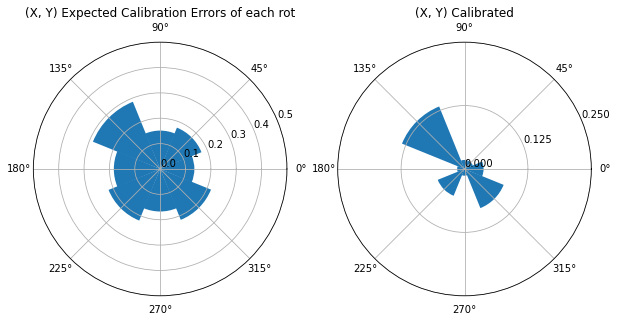

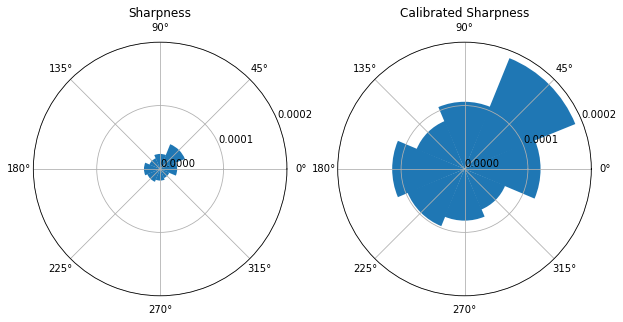

In [13]:
def make_cov_corr(df):
    variance_pred = df[["varX", "varY"]].to_numpy()
    corr = df.xy_correlation_pred.to_numpy()
    cov_pred = np.array([
        np.array([
            [vx, np.sqrt(vx * vy) * c],
            [np.sqrt(vx * vy) * c, vy],
        ])
        for (vx, vy), c in zip(variance_pred, corr)])
    return cov_pred

def model_corr(gt, pred, cov, rot):
    method = "optim"
    # method = "scaling"
    # method = "mahalanobis"
    # method = "nll"

    if method == "scaling":
        invT0 = np.sum((gt[:,0] - pred[:,0]) ** 2) / cov[:,0,0].sum()
        invT1 = np.sum((gt[:,1] - pred[:,1]) ** 2) / cov[:,1,1].sum()
        invT01 = np.sqrt(invT0 * invT1)
        # invT0 = invT01
        # invT1 = invT01
    elif method == "mahalanobis":
        diff = gt - pred
        maha = (diff[:,None,:] @ np.linalg.inv(cov) @ diff[:,:,None]).ravel()
        invT01 = maha.mean()/2
        invT0 = invT01
        invT1 = invT01
    elif method == "nll":
        invT0 = np.mean((gt[:,0] - pred[:,0]) ** 2 / cov[:,0,0])
        invT1 = np.mean((gt[:,1] - pred[:,1]) ** 2 / cov[:,1,1])
        invT01 = np.sqrt(invT0 * invT1)
    elif method == "optim":
        def fn(loginvT):
            invT = np.exp(loginvT)
            prob_true, prob_pred = reg_calibration_curve_nd(gt, pred, cov * invT, 20)
            return np.abs(prob_true - prob_pred).mean()
        result = minimize_scalar(fn)
        print(result)
        invT01 = np.exp(result.x)
        invT0 = invT01
        invT1 = invT01
    return (lambda cov, rot: np.array([v * np.array([[invT0, invT01], [invT01, invT1]]) for v in cov]))

show(model_corr, cov_fn=make_cov_corr)

ECE: 0.16525724263578134
Sharpness: 2.1331218978488353e-05
calibrated ECE: 0.01075757409980258
calibrated Sharpness: 9.78796187865364e-05


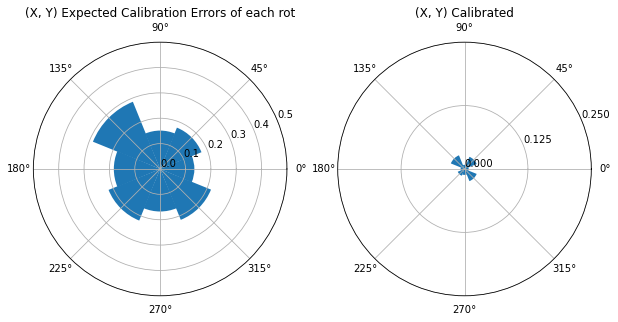

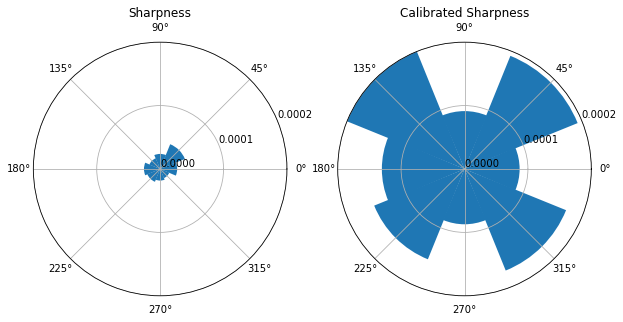

In [14]:
def model_rot(gt, pred, cov, rot):
    method = "optim"

    if method == "optim":
        n_zbins = 8
        zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
        zbinids = np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1
        invTs = np.zeros(n_zbins)

        def fn(loginvT, _gt, _pred, _cov):
            invT = np.exp(loginvT)
            prob_true, prob_pred = reg_calibration_curve_nd(_gt, _pred, _cov * invT, 20)
            return np.abs(prob_true - prob_pred).mean()

        for zi in range(n_zbins):
            result = minimize_scalar(
                fn,
                args=(gt[zbinids == zi], pred[zbinids == zi], cov[zbinids == zi]),
            )
            invTs[zi] = np.exp(result.x)
    return (lambda cov, rot: np.array([v * invTs[zi] for v, zi in zip(cov, np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1)]))

show(model_rot, cov_fn=make_cov_corr)


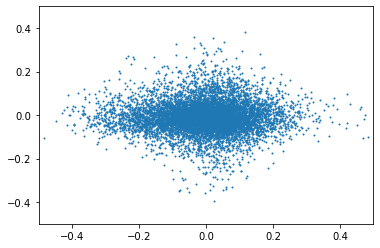

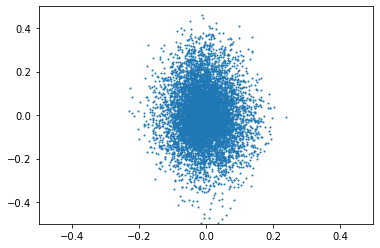

In [15]:
pred = df[["X", "Y"]].to_numpy()
gt = df[["Xgt", "Ygt"]].to_numpy()
rot = df.Rot.to_numpy()
diff = pred - gt

n_zbins = 8
zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
zbinids = np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1
# diff = diff[zbinids == 2]

plt.scatter(diff[:,0], diff[:,1], s=1)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.show()

rmat = lambda r: np.array([[np.cos(r), np.sin(r)], [-np.sin(r), np.cos(r)]])
rpred = np.array([(p - g) @ rmat(r) + g for p,g,r in zip(pred, gt, rot)])
rdiff = rpred - gt
# rdiff = rdiff[zbinids == 2]
plt.scatter(rdiff[:,0], rdiff[:,1], s=1)
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.show()

ECE: 0.16525724263578134
Sharpness: 2.1331218978488353e-05
1.9282163136989785 3.096181325558239
1.8925143171977676 3.1609413069196455
1.8791261487999236 3.0777500072397594
calibrated ECE: 0.03541629070875885
calibrated Sharpness: 0.00012610829643242442


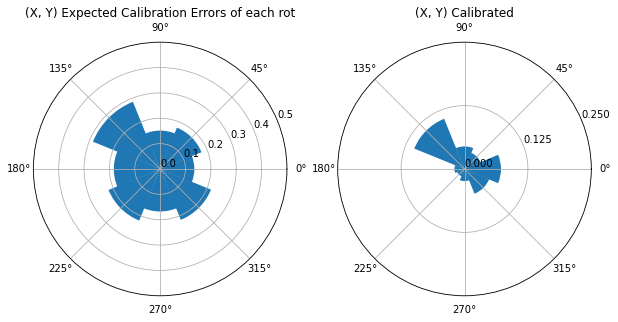

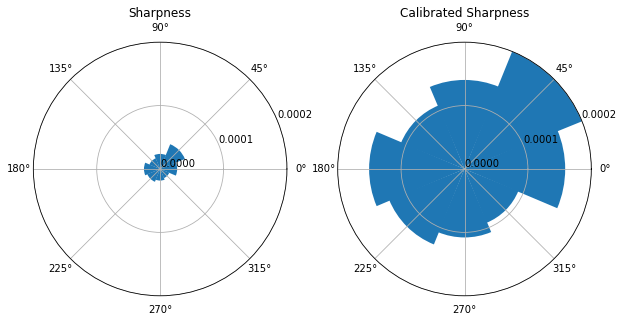

In [18]:
def model_rot2(gt, pred, cov, rot):
    rmat = lambda r: np.array([[np.cos(r), np.sin(r)], [-np.sin(r), np.cos(r)]])

    rcov = np.array([rmat(r) @ c @ rmat(-r) for c,r in zip(cov, rot)])
    rpred = np.array([(p - g) @ rmat(r) + g for p,g,r in zip(pred, gt, rot)])
    mod = model(gt, rpred, rcov, rot)
    return (lambda cov, rot: np.array([rmat(r) @ mod([rmat(-r) @ c @ rmat(r)], [r])[0] @ rmat(-r) for c, r in zip(cov, rot)]))

show(model_rot2, cov_fn=make_cov_corr)


ECE: 0.16525724263578134
Sharpness: 2.1331218978488353e-05
1.5934982610777988 1.925932424374158
1.7803137914995104 1.7468127274156846
2.035581051258026 2.638587826409559
3.2230761877176626 3.327504228966415
1.885408964595372 2.6705260813245966
1.5184268742323819 3.689170429171306
1.8952176308095843 3.5403811966604675
1.7769038920560796 5.273398028400087
1.6249500264204195 1.897065558453279
1.4596262821472539 2.1299395717873297
1.9814580613864015 2.670322346654331
2.9419046910967044 3.429934358030175
1.8500683698499414 2.5944156770252054
1.2773558044533135 3.569121828367996
1.8890719374779243 3.6518258491749314
1.4960555123265278 5.41913562237866
1.64568406851502 2.0548828716047147
1.8527286734166601 2.3163837181464677
1.9403985864071485 2.6469134965270675
2.717802368745135 3.3876609903764487
1.8487965363979442 2.5310553611516835
1.5021609788854262 3.6739532051025985
1.8737847648261556 3.5065733272598067
1.6439378614057056 4.642987131763795
calibrated ECE: 0.030598834222231634
calibrate

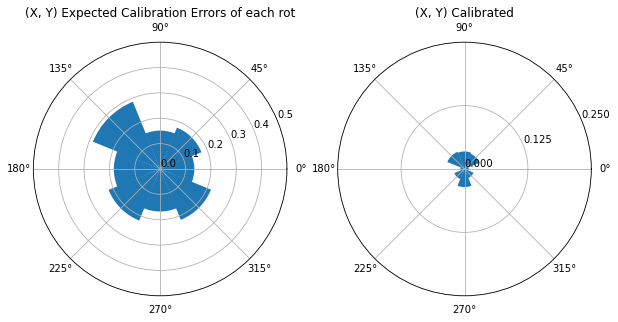

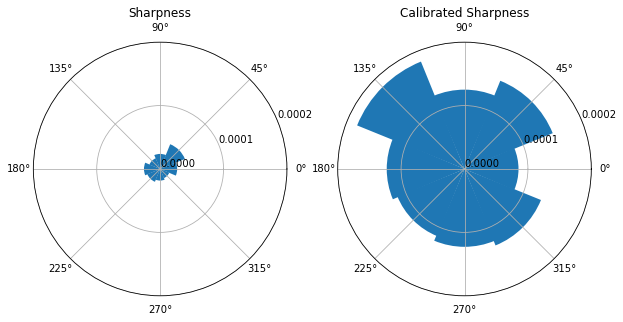

In [24]:
def model_rot3(gt, pred, cov, rot):
    rmat = lambda r: np.array([[np.cos(r), np.sin(r)], [-np.sin(r), np.cos(r)]])
    rcov = np.array([rmat(r) @ c @ rmat(-r) for c,r in zip(cov, rot)])
    rpred = np.array([(p - g) @ rmat(r) + g for p,g,r in zip(pred, gt, rot)])

    n_zbins = 8
    zbins = np.linspace(0, 2*np.pi, n_zbins+1, endpoint=True)
    zbinids = np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1
    mods = [None for _ in range(n_zbins)]

    for zi in range(n_zbins):
        mods[zi] = model(gt[zbinids == zi], rpred[zbinids == zi], rcov[zbinids == zi], rot[zbinids == zi])

    return (lambda cov, rot: np.array([rmat(r) @ mods[zi]([rmat(-r) @ c @ rmat(r)], [r])[0] @ rmat(-r) for c, r, zi in zip(cov, rot, np.digitize((rot + np.pi/n_zbins) % (2*np.pi), zbins) - 1)]))

show(model_rot3, cov_fn=make_cov_corr)
